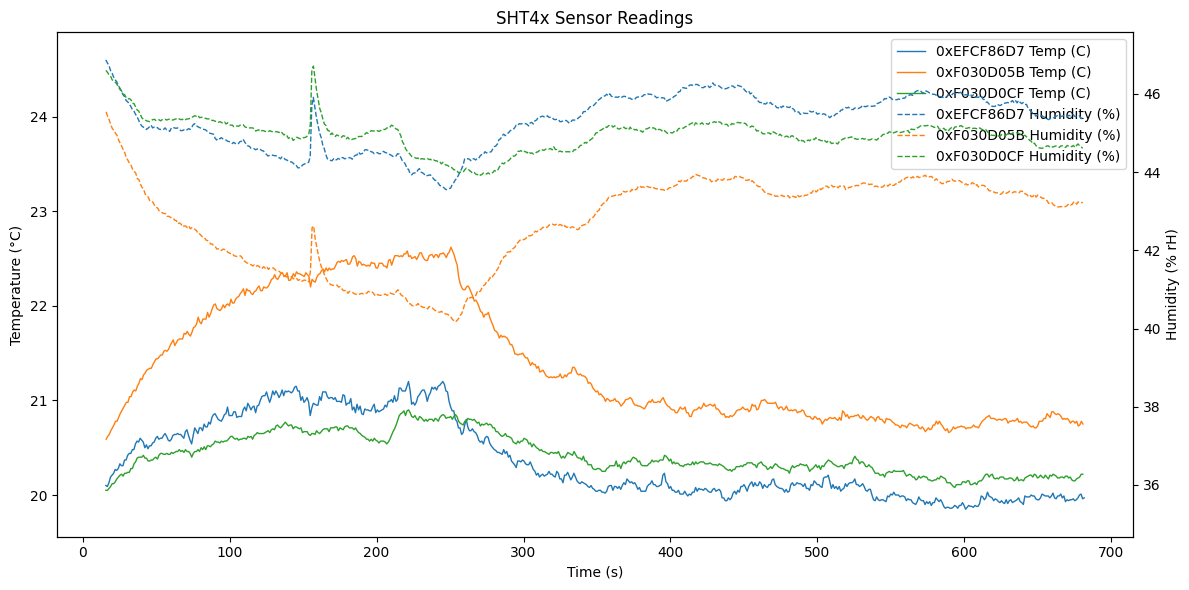

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = 'sensor_readings_20250522_110310.csv'
df = pd.read_csv(csv_file)
df['time_s'] = df['timestamp'] / 1000.0

# Function to calculate absolute humidity (g/m³)
def calc_absolute_humidity(temp_c, rh):
    # Formula: AH = 6.112 * exp((17.67*T)/(T+243.5)) * RH * 2.1674 / (273.15+T)
    # T in °C, RH in %, AH in g/m³
    return 6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh * 2.1674 / (273.15 + temp_c) / 100


serials = set()
for col in df.columns:
    if '_temperature' in col:
        serials.add(col.replace('_temperature (degrees C)', ''))

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

for serial in serials:
    temp_col = f"{serial}_temperature (degrees C)"
    hum_col = f"{serial}_humidity (% rH)"
    # Plot only where data exists (drop NaNs)
    temp_data = df[['time_s', temp_col]].dropna()
    hum_data = df[['time_s', hum_col]].dropna()
    ax1.plot(temp_data['time_s'], temp_data[temp_col], label=f"{serial} Temp (C)", linewidth=1)
    ax2.plot(hum_data['time_s'], hum_data[hum_col], linestyle='--', label=f"{serial} Humidity (%)", linewidth=1)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Humidity (% rH)')
ax1.set_title('SHT4x Sensor Readings')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

temp_dynamic_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
rh_dynamic_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]

ax1.set_ylim(ax1.get_ylim()[0] - 0.05 * temp_dynamic_range, ax1.get_ylim()[1] + 0.7 * temp_dynamic_range)
ax2.set_ylim(ax2.get_ylim()[0] - 0.7 * rh_dynamic_range, ax2.get_ylim()[1] + 0.05 * rh_dynamic_range)

plt.tight_layout()
plt.show()

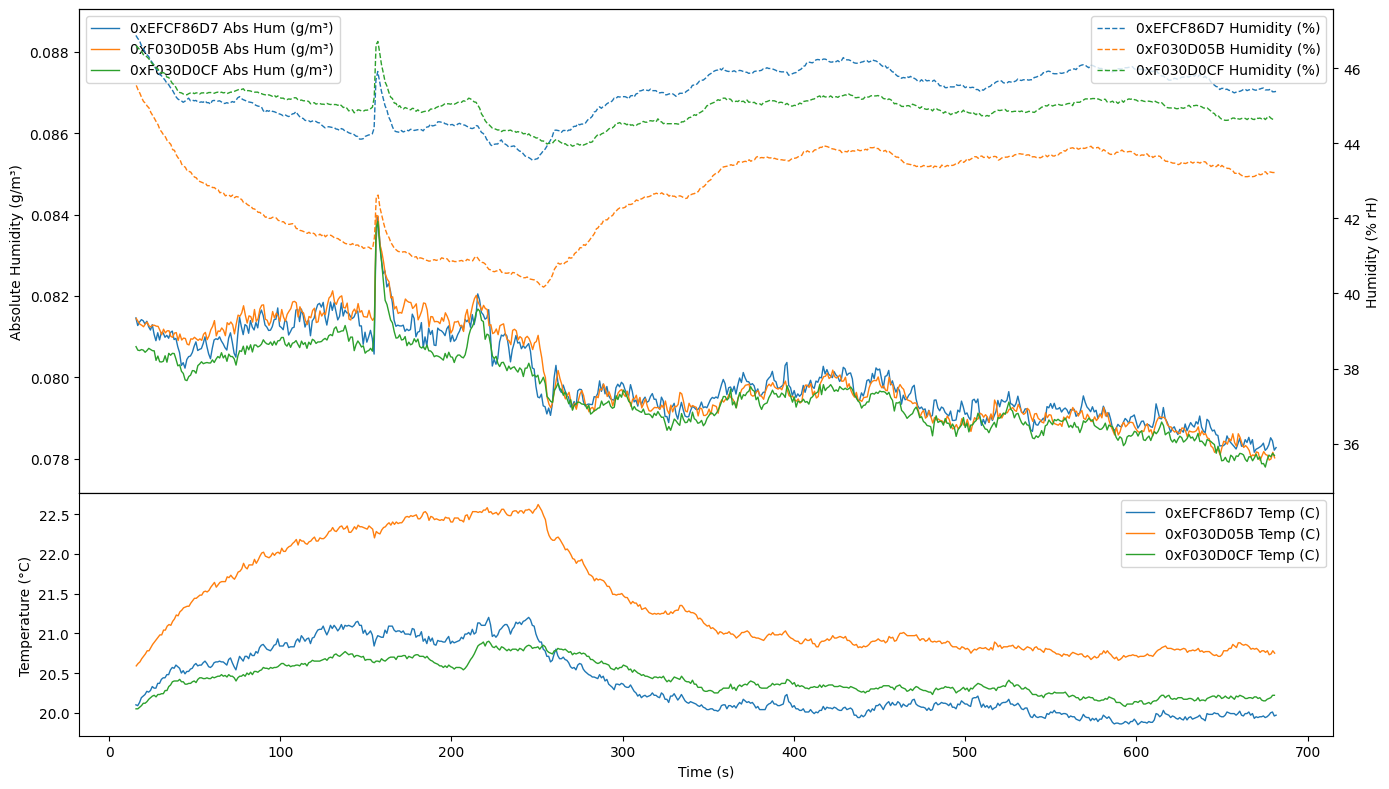

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_file = 'sensor_readings_20250522_110310.csv'
df = pd.read_csv(csv_file)
df['time_s'] = df['timestamp'] / 1000.0

def calc_absolute_humidity(temp_c, rh):
    # Formula: AH = 6.112 * exp((17.67*T)/(T+243.5)) * RH * 2.1674 / (273.15+T)
    return 6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh * 2.1674 / (273.15 + temp_c) / 100

serials = set()
for col in df.columns:
    if '_temperature' in col:
        serials.add(col.replace('_temperature (degrees C)', ''))

fig, (ax_ah, ax_temp) = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0}
)
ax_rh = ax_ah.twinx()

for serial in serials:
    temp_col = f"{serial}_temperature (degrees C)"
    hum_col = f"{serial}_humidity (% rH)"
    valid = df[['time_s', temp_col, hum_col]].dropna()
    hum_data = df[['time_s', hum_col]].dropna()
    temp_data = df[['time_s', temp_col]].dropna()
    if not valid.empty:
        abs_hum = calc_absolute_humidity(valid[temp_col], valid[hum_col])
        ax_ah.plot(valid['time_s'], abs_hum, label=f"{serial} Abs Hum (g/m³)", linewidth=1)
    if not hum_data.empty:
        ax_rh.plot(hum_data['time_s'], hum_data[hum_col], linestyle='--', label=f"{serial} Humidity (%)", linewidth=1)
    if not temp_data.empty:
        ax_temp.plot(temp_data['time_s'], temp_data[temp_col], label=f"{serial} Temp (C)", linewidth=1)

# Adjust y-limits to reduce overlay between abs humidity and humidity
ah_ylim = ax_ah.get_ylim()
rh_ylim = ax_rh.get_ylim()
ah_dynamic_range = (ah_ylim[1] - ah_ylim[0])
rh_dynamic_range = (rh_ylim[1] - rh_ylim[0])
ax_ah.set_ylim(ah_ylim[0] - ah_dynamic_range * 0.05, ah_ylim[1] + ah_dynamic_range * 0.7)
ax_rh.set_ylim(rh_ylim[0] - rh_dynamic_range * 0.7, rh_ylim[1] + rh_dynamic_range * 0.05)

ax_ah.set_ylabel('Absolute Humidity (g/m³)')
ax_rh.set_ylabel('Humidity (% rH)')
ax_temp.set_xlabel('Time (s)')
ax_temp.set_ylabel('Temperature (°C)')

ax_ah.legend(loc='upper left')
ax_rh.legend(loc='upper right')
ax_temp.legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()